<a href="https://colab.research.google.com/github/nurmayadi/learn-machine-learning/blob/main/energy_consumptions_prediction_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Proyek Kedua Belajar Pengembangan Machine Learning

##Fitra Nurmayadi


Pada proyek kedua ini, saya menggunakan dataset penggunaan energi listrik rumah tangga. Dataset didapatkan dari kaggle : https://www.kaggle.com/datasets/jaganadhg/house-hold-energy-data?select=D202.csv.


##Import Library

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from keras.layers import Dense, LSTM


In [2]:
!pip install -q kaggle

In [3]:
import json
dictionary = {"username":"fitranurmayadi","key":"41904ce5805c3bb261bff4ae8d16a6b0"}
json_object = json.dumps(dictionary, indent=4)
with open("kaggle.json", "w") as outfile:
    outfile.write(json_object)

In [4]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

##Data Acquisition

In [5]:
!kaggle datasets download -d jaganadhg/house-hold-energy-data

 78% 2.00M/2.58M [00:01<00:00, 2.12MB/s]
100% 2.58M/2.58M [00:01<00:00, 2.28MB/s]


In [6]:
!unzip -q house-hold-energy-data.zip -d "dataset"

In [7]:
df = pd.read_csv('dataset/D202.csv')
df

,TYPE,DATE,START TIME,END TIME,USAGE,UNITS,COST,NOTES
0,Electric usage,10/22/2016,0:00,0:14,0.01,kWh,$0.00,NaN
1,Electric usage,10/22/2016,0:15,0:29,0.01,kWh,$0.00,NaN
2,Electric usage,10/22/2016,0:30,0:44,0.01,kWh,$0.00,NaN
3,Electric usage,10/22/2016,0:45,0:59,0.01,kWh,$0.00,NaN
4,Electric usage,10/22/2016,1:00,1:14,0.01,kWh,$0.00,NaN
...,...,...,...,...,...,...,...,...
70363,Electric usage,10/24/2018,22:45,22:59,0.02,kWh,$0.00,NaN
70364,Electric usage,10/24/2018,23:00,23:14,0.03,kWh,$0.01,NaN
70365,Electric usage,10/24/2018,23:15,23:29,0.03,kWh,$0.01,NaN
70366,Electric usage,10/24/2018,23:30,23:44,0.03,kWh,$0.01,NaN


##Data Understanding

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70368 entries, 0 to 70367
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   TYPE        70368 non-null  object 
 1   DATE        70368 non-null  object 
 2   START TIME  70368 non-null  object 
 3   END TIME    70368 non-null  object 
 4   USAGE       70368 non-null  float64
 5   UNITS       70368 non-null  object 
 6   COST        70368 non-null  object 
 7   NOTES       0 non-null      float64
dtypes: float64(2), object(6)
memory usage: 4.3+ MB


In [9]:
df.isnull().sum()

TYPE              0
DATE              0
START TIME        0
END TIME          0
USAGE             0
UNITS             0
COST              0
NOTES         70368
dtype: int64

Pada dataset, dapat dilihat bahwa hanya data 'usage' yang dapat digunakan sebagai parameter pelatihan, karena beberapa parameter seperti type, units,cost, dan notes tidak menunjukan kegunaan yang lebih untuk pelatihan

##Data Cleaning

Menghapus kolom yang tidak diperlukan dan mengubah  waktu pengukuran ke satu kolom timestamp, lalu mengubah rentang waktu dari 15 menit ke tiap 1 jam

In [10]:
df = df.drop(columns=['TYPE','UNITS','END TIME','NOTES','COST'])

In [11]:
add_prefix_lambda = lambda start_time: "0"+ start_time if int(start_time.split(":")[0]) < 12 else start_time
df["START TIME"] = df["START TIME"].apply(add_prefix_lambda)

df["timestamp"] = df["DATE"] + " " + df["START TIME"]
df["timestamp"] = pd.to_datetime(df["timestamp"])

df = df[["timestamp", "USAGE"]]
df.columns = ["timestamp", "usage"]

In [12]:
df.head()

,timestamp,usage
0,2016-10-22 00:00:00,0.01
1,2016-10-22 00:15:00,0.01
2,2016-10-22 00:30:00,0.01
3,2016-10-22 00:45:00,0.01
4,2016-10-22 01:00:00,0.01


##Data Preparation

Resampling: mengubah format data kedalam rentang waktu setiap jam

In [13]:
hourly_df = df.resample("1H", on="timestamp").sum()

In [14]:
hourly_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17592 entries, 2016-10-22 00:00:00 to 2018-10-24 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   usage   17592 non-null  float64
dtypes: float64(1)
memory usage: 274.9 KB


In [15]:
hourly_df.head()

,usage
timestamp,
2016-10-22 00:00:00,0.04
2016-10-22 01:00:00,0.04
2016-10-22 02:00:00,0.08
2016-10-22 03:00:00,0.04
2016-10-22 04:00:00,0.04


In [16]:
data = hourly_df['usage']
data

timestamp
2016-10-22 00:00:00    0.04
2016-10-22 01:00:00    0.04
2016-10-22 02:00:00    0.08
2016-10-22 03:00:00    0.04
2016-10-22 04:00:00    0.04
                       ... 
2018-10-24 19:00:00    0.12
2018-10-24 20:00:00    0.12
2018-10-24 21:00:00    0.12
2018-10-24 22:00:00    0.08
2018-10-24 23:00:00    0.12
Freq: H, Name: usage, Length: 17592, dtype: float64

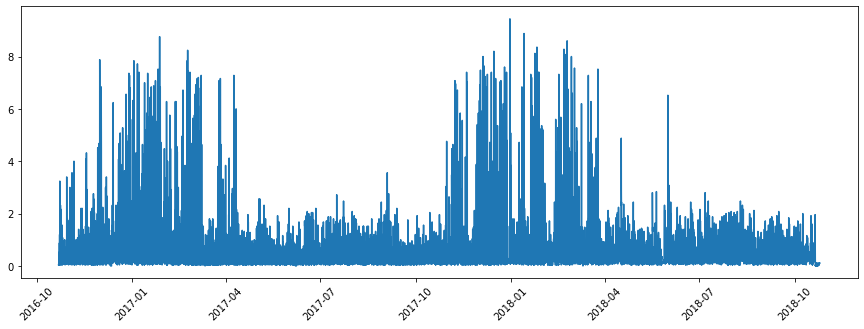

In [17]:
plt.figure(figsize=(15,5))
plt.plot(hourly_df.loc["2016-10-22": "2018-10-24", "usage"])
plt.xticks(rotation=45)
plt.show()

Untuk dataset, digunakan dataset yang telah dibuat ke dalam satuan harian

In [18]:
hourly_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17592 entries, 2016-10-22 00:00:00 to 2018-10-24 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   usage   17592 non-null  float64
dtypes: float64(1)
memory usage: 790.9 KB


In [19]:
data = hourly_df['usage'].values
data = data.reshape(-1,1)
data

array([[0.04],
       [0.04],
       [0.08],
       ...,
       [0.12],
       [0.08],
       [0.12]])

##Data Normalization

In [20]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(data)

##MAE Threshold check

In [21]:
threshold_mae = (dataset.max() - dataset.min()) * 10/100
threshold_mae

0.1

##Split Data to 80:20

In [22]:
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))
train = train.flatten()
test = test.flatten()

14073 3519


##Data Formatting for LSTM network

In [23]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [24]:
train_set = windowed_dataset(train, window_size=60, batch_size=100, shuffle_buffer=1000)

In [25]:
test_set = windowed_dataset(test, window_size=60, batch_size=100, shuffle_buffer=1000)

##Model Design

In [26]:
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(60, return_sequences=True, dropout=0.25, recurrent_dropout=0.25),
  tf.keras.layers.LSTM(60),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
   tf.keras.layers.Dropout(0.25),
  tf.keras.layers.Dense(1),
])

In [28]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae", "accuracy"])

In [30]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint('weights.hdf5', monitor='accuracy', save_best_only=True)
early_stop = EarlyStopping(monitor='accuracy', patience=10)

##Model Train

In [31]:
history = model.fit(
    train_set,
    epochs=100,
    callbacks=[checkpoint, early_stop]
)

Epoch 1/100
141/141 [==============================] - 40s 227ms/step - loss: 0.0058 - mae: 0.0468 - accuracy: 0.0036
Epoch 2/100
141/141 [==============================] - 33s 232ms/step - loss: 0.0051 - mae: 0.0439 - accuracy: 0.0036
Epoch 3/100
141/141 [==============================] - 32s 224ms/step - loss: 0.0048 - mae: 0.0473 - accuracy: 0.0036
Epoch 4/100
141/141 [==============================] - 33s 234ms/step - loss: 0.0048 - mae: 0.0497 - accuracy: 0.0036
Epoch 5/100
141/141 [==============================] - 31s 222ms/step - loss: 0.0047 - mae: 0.0510 - accuracy: 0.0036
Epoch 6/100
141/141 [==============================] - 32s 226ms/step - loss: 0.0047 - mae: 0.0517 - accuracy: 0.0036
Epoch 7/100
141/141 [==============================] - 33s 230ms/step - loss: 0.0047 - mae: 0.0519 - accuracy: 0.0036
Epoch 8/100
141/141 [==============================] - 31s 222ms/step - loss: 0.0047 - mae: 0.0522 - accuracy: 0.0036
Epoch 9/100
141/141 [==============================] - 3

##Plotting

Plot metric loss dan akurasi pada data train, metric validation tidak tersedia

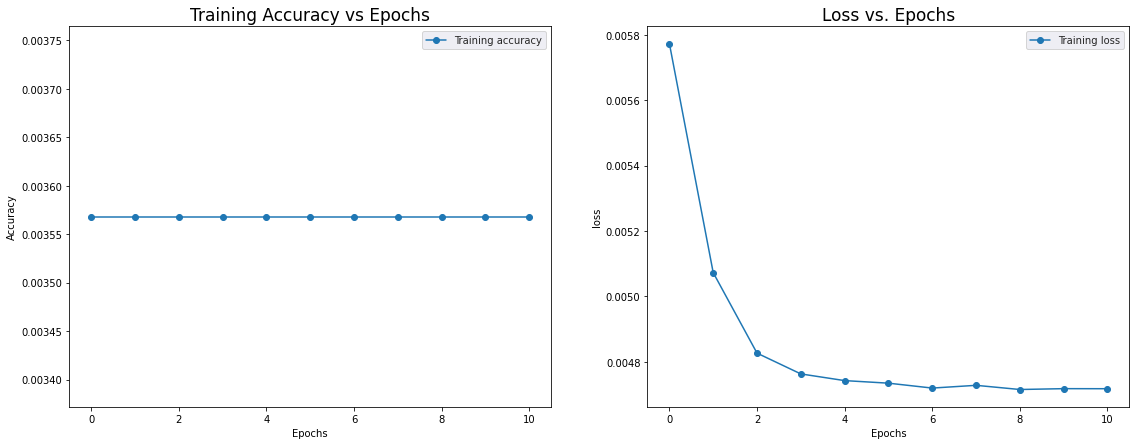

In [32]:
acc = history.history['accuracy']
loss = history.history['loss']

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (19,7))
sns.set_style("darkgrid")

ax[0].plot(acc, 'o-',label = 'Training accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Training Accuracy vs Epochs', fontsize = 17)
ax[0].legend(loc='best')


ax[1].plot(loss, 'o-',label = 'Training loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('loss')
ax[1].set_title('Loss vs. Epochs', fontsize = 17)
ax[1].legend(loc='best')
sns.set_style("darkgrid")

##Model Evaluate

In [33]:
model.load_weights('weights.hdf5')
loss_acc = model.evaluate(train_set)
print('Test set\n  Loss: {:0.3f}\n  MAE: {:0.3f}\n  Accuracy: {:0.3f}'.format(loss_acc[0],loss_acc[1],loss_acc[2]))

141/141 [==============================] - 6s 35ms/step - loss: 0.0053 - mae: 0.0424 - accuracy: 0.0036
Test set
  Loss: 0.005
  MAE: 0.042
  Accuracy: 0.004


In [34]:
model.load_weights('weights.hdf5')
loss_acc = model.evaluate(test_set)
print('Test set\n  Loss: {:0.3f}\n  MAE: {:0.3f}\n  Accuracy: {:0.3f}'.format(loss_acc[0],loss_acc[1],loss_acc[2]))

35/35 [==============================] - 1s 30ms/step - loss: 0.0011 - mae: 0.0267 - accuracy: 0.0058
Test set
  Loss: 0.001
  MAE: 0.027
  Accuracy: 0.006


##Model Testing

In [35]:
train_prediction = model.predict(train_set)
train_predict = train_prediction

141/141 [==============================] - 5s 29ms/step


In [36]:
test_prediction = model.predict(test_set)
test_predict = test_prediction

35/35 [==============================] - 1s 27ms/step


plot prediction

In [37]:
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[:len(train_predict), :] = train_predict

In [38]:
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+120:len(dataset), :] = test_predict

In [39]:
allPredict = np.empty_like(dataset)
allPredict[:, :] = np.nan
allPredict[:len(train_predict), :] = train_predict
allPredict[len(train_predict)+120:len(dataset), :] = test_predict
allPredict

array([[0.01930315],
       [0.0209571 ],
       [0.02084618],
       ...,
       [0.01920879],
       [0.01835577],
       [0.01971402]])

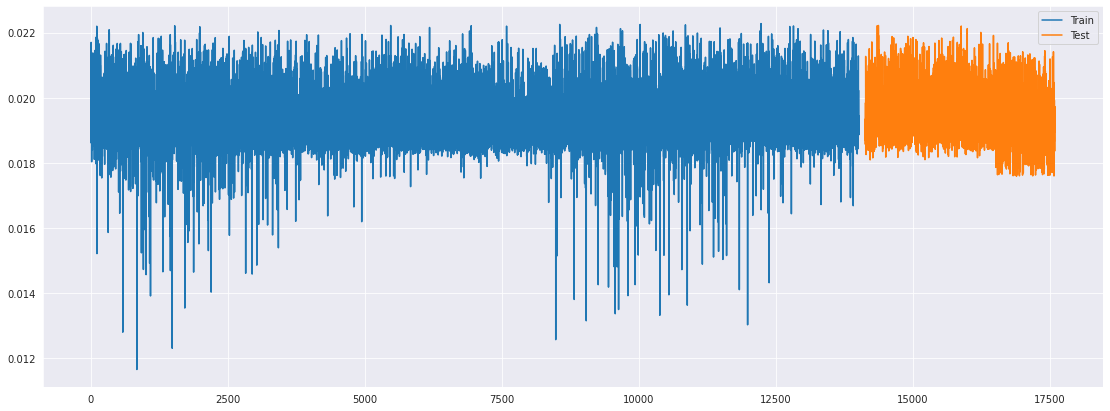

In [40]:
plt.figure(figsize=(19,7))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.legend(['Train','Test'], loc='best')
plt.show()